## PACS Domain Generalization with Vision Transformer (ViT)

## Setup & Imports

In [ ]:

import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.model_selection import train_test_split
from transformers import ViTForImageClassification, ViTFeatureExtractor
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random


## Configuration & Seeds

In [9]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")
SEED = 42
BATCH_SIZE = 24
NUM_EPOCHS = 5
NUM_CLASSES = 7
DATA_ROOT = "../../../pacs_data/pacs_data"
DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]
MODELS = {
    "base": "google/vit-base-patch16-224-in21k",
    "small": "WinKawaks/vit-small-patch16-224",
    "tiny": "WinKawaks/vit-tiny-patch16-224"
    }

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


Device: cuda


In [10]:
# =================================================================================
# GRQO Model and Training Hyperparameters
# =================================================================================
NUM_QUERIES = 30           # Number of learnable queries for the decoder
NUM_DECODER_LAYERS = 2     # Number of layers in the Transformer Decoder
DECODER_NHEAD = 8          # Number of attention heads in the decoder

# GRQO Loss weights
GRQO_ALPHA = 1.0           # Weight for the policy/reward loss
GRQO_BETA = 0.05           # Weight for the KL-divergence regularization

# Two-Stage Training
WARMUP_EPOCHS = 1          # Number of SFT warm-up epochs before GRQO starts

## Dataset Wrapper Class

In [11]:

class PACSDataset:
    def __init__(self, data_root, domains, transform):
        self.data_root = data_root
        self.domains = domains
        self.transform = transform

    def get_dataloader(self, domain, train=True):
        dataset = datasets.ImageFolder(os.path.join(self.data_root, domain), transform=self.transform)
        
        indices = list(range(len(dataset)))
        train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=[dataset.targets[i] for i in indices], random_state=SEED)
        selected_idx = train_idx if train else val_idx
        
        subset = Subset(dataset, selected_idx)
        loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=train)
        return loader


## Vision Transformer Wrapper Class

In [12]:
# =================================================================================
# Vision Transformer GRQO Wrapper Class (Replaces the old ViTModel)
# =================================================================================

from transformers import ViTModel # <-- Note the change from ViTForImageClassification

class ViT_GRQO_Model(nn.Module):
    """
    A hybrid Vision Transformer (ViT) and Transformer Decoder model inspired by DETR/DINO.
    This model adapts the architecture for a classification task trained with GRQO.
    """
    def __init__(self,
                 num_classes,
                 model_size="base",
                 num_queries=30,
                 num_decoder_layers=2,
                 decoder_nhead=8):
        """
        Initializes the hybrid model.

        Args:
            num_classes (int): The number of output classes.
            model_size (str): The size of the ViT model ('base', 'small', 'tiny').
            num_queries (int): The number of learnable "object queries" to use in the decoder.
            num_decoder_layers (int): The number of layers in the Transformer Decoder.
            decoder_nhead (int): The number of attention heads in the Transformer Decoder.
        """
        super().__init__()
        
        model_name = MODELS[model_size]
        
        # 1. Load the ViT model as a feature extractor (backbone)
        # We use ViTModel to get the raw hidden states, not the final classification output.
        self.model = ViTModel.from_pretrained(model_name)
        
        # Get the embedding dimension from the ViT config
        embed_dim = self.model.config.hidden_size
        self.embed_dim = embed_dim
        self.num_queries = num_queries

        # 2. Create the learnable query embeddings
        self.query_embed = nn.Embedding(num_queries, embed_dim)

        # 3. Create the Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=decoder_nhead,
            batch_first=True  # Important for easier tensor manipulation
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        # 4. Create the final classification head (MLP)
        # This single head will be applied to the output of every query
        self.classifier = nn.Linear(embed_dim, num_classes)
        
        print(f"Initialized ViT-GRQO Model (ViT-{model_size}) with {num_queries} queries.")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the forward pass of the model.

        Args:
            x (torch.Tensor): Input batch of images with shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Logits for each query, with shape (batch_size, num_queries, num_classes).
        """
        # 1. Get image features from the ViT backbone
        # We don't use the pooler output, just the sequence of patch embeddings
        outputs = self.model(pixel_values=x)
        patch_embeds = outputs.last_hidden_state # Shape: (batch_size, num_patches + 1, embed_dim)
        
        # We don't strictly need to remove the [CLS] token, but it's good practice
        patch_embeds = patch_embeds[:, 1:, :] # Shape: (batch_size, num_patches, embed_dim)

        # 2. Prepare the queries for the decoder
        # Get the learnable query vectors and expand them for the batch
        query_embed = self.query_embed.weight.unsqueeze(0).repeat(x.size(0), 1, 1)

        # 3. Pass features and queries through the decoder
        # `query_embed` is the target (tgt), `patch_embeds` is the memory
        decoder_output = self.decoder(tgt=query_embed, memory=patch_embeds)
        # Shape: (batch_size, num_queries, embed_dim)

        # 4. Apply the classifier to each query's output
        logits = self.classifier(decoder_output)
        # Shape: (batch_size, num_queries, num_classes)

        return logits

## Trainer Class

In [13]:
# =================================================================================
# Trainer Class (Final Version with Two-Stage Training)
# =================================================================================
import torch.nn.functional as F
import copy

class Trainer:
    """
    A trainer class to handle the training and evaluation loop.
    Implements a two-stage training process:
    1. SFT Warm-up: Standard supervised fine-tuning for a set number of epochs.
    2. GRQO Training: Reinforcement-style training with a composite loss.
    """
    def __init__(self, model, optimizer, criterion, grqo_alpha=1.0, grqo_beta=0.05, warmup_epochs=1):
        """
        Initializes the Trainer.

        Args:
            model: The model to be trained (ViT_GRQO_Model).
            optimizer: The optimizer.
            criterion: The base loss function (e.g., CrossEntropyLoss).
            grqo_alpha (float): The weight for the GRQO policy loss.
            grqo_beta (float): The weight for the KL-divergence regularization loss.
            warmup_epochs (int): Number of epochs for the SFT warm-up phase.
        """
        self.model = model.to(DEVICE)
        self.optimizer = optimizer
        self.criterion = criterion
        
        # Store GRQO and warm-up hyperparameters
        self.alpha = grqo_alpha
        self.beta = grqo_beta
        self.warmup_epochs = warmup_epochs
        
        # Initialize the reference model placeholder
        self.ref_model = None
        
        print(f"Initialized Trainer with {self.warmup_epochs} SFT warm-up epoch(s).")
        print(f"GRQO params (alpha={self.alpha}, beta={self.beta}) will activate after warm-up.")
        
    def update_reference_model(self):
        """
        Creates/updates a frozen, deep copy of the current model to be used as the
        reference model for KL-divergence calculation.
        """
        if self.ref_model is None:
            print("--- Initializing reference model for GRQO phase ---")
            self.ref_model = copy.deepcopy(self.model)
        else:
            self.ref_model.load_state_dict(self.model.state_dict())
        
        # Freeze the reference model
        self.ref_model.eval()
        for param in self.ref_model.parameters():
            param.requires_grad = False

    def train(self, dataloader, current_epoch: int):
        """
        Runs a single training epoch. The behavior depends on the current epoch.
        """
        self.model.train()
        total_loss_epoch = 0
        
        desc = f"Epoch {current_epoch+1} (SFT Mode)" if current_epoch < self.warmup_epochs else f"Epoch {current_epoch+1} (GRQO Mode)"

        for inputs, labels in tqdm(dataloader, desc=desc):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # --- SFT Warm-up Mode ---
            if current_epoch < self.warmup_epochs:
                # 1. Forward pass on active model
                active_logits = self.model(inputs)
                # 2. Average predictions for standard classification loss
                avg_active_logits = active_logits.mean(dim=1)
                # 3. Calculate simple SFT loss
                total_loss = self.criterion(avg_active_logits, labels)

            # --- GRQO Mode ---
            else:
                # --- Forward Passes ---
                active_logits = self.model(inputs)
                with torch.no_grad():
                    ref_logits = self.ref_model(inputs)

                # --- Loss Calculation ---
                # Component 1: SFT Loss
                avg_active_logits = active_logits.mean(dim=1)
                loss_sft = self.criterion(avg_active_logits, labels)

                # Component 2: GRQO Policy Loss
                per_query_loss = F.cross_entropy(
                    active_logits.permute(0, 2, 1), 
                    labels.unsqueeze(1).repeat(1, self.model.num_queries), 
                    reduction='none'
                )
                rewards = -per_query_loss
                advantages = ((rewards - rewards.mean(dim=1, keepdim=True)) / 
                              (rewards.std(dim=1, keepdim=True) + 1e-9)).detach()
                log_probs = F.log_softmax(active_logits, dim=-1)
                gt_log_probs = log_probs.gather(2, labels.view(-1, 1, 1).repeat(1, self.model.num_queries, 1)).squeeze(-1)
                loss_grqo = - (advantages * gt_log_probs).mean()
                
                # Component 3: KL-Divergence Loss
                loss_kl = F.kl_div(
                    F.log_softmax(active_logits, dim=-1),
                    F.softmax(ref_logits.detach(), dim=-1),
                    reduction='batchmean'
                )
                
                # --- Total Composite Loss ---
                total_loss = loss_sft + self.alpha * loss_grqo + self.beta * loss_kl
            
            # --- Backpropagation (common to both modes) ---
            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()
            
            total_loss_epoch += total_loss.item()
            
        return total_loss_epoch / len(dataloader)

    def evaluate(self, dataloader):
        """
        Runs a single evaluation epoch (no changes needed here).
        """
        self.model.eval()
        total_correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in tqdm(dataloader, desc="Evaluating"):
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = self.model(inputs)
                avg_outputs = outputs.mean(dim=1)
                preds = torch.argmax(avg_outputs, dim=1)
                total_correct += (preds == labels).sum().item()
                total += labels.size(0)
        return total_correct / total

## Base ViT

### Leave-One-Domain-Out (LODO) Training

In [14]:
# =================================================================================
# GRQO + ViT Base Leave-One-Domain-Out (LODO) Training (Corrected)
# =================================================================================

# Define the image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

results_base = {}
for test_domain in DOMAINS:
    print(f"---[ViT Base]--- Testing on domain: {test_domain} ---")
    train_domains = [d for d in DOMAINS if d != test_domain]
    dataset = PACSDataset(DATA_ROOT, DOMAINS, transform)
    train_loaders = [dataset.get_dataloader(d, train=True) for d in train_domains]
    val_loaders = [dataset.get_dataloader(d, train=False) for d in train_domains]
    test_loader = dataset.get_dataloader(test_domain, train=False)
    train_ds = ConcatDataset([dl.dataset for dl in train_loaders])
    val_ds = ConcatDataset([dl.dataset for dl in val_loaders])
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    
    model_base = ViT_GRQO_Model(NUM_CLASSES, "base", NUM_QUERIES, NUM_DECODER_LAYERS, DECODER_NHEAD)
    optimizer = optim.Adam(model_base.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    trainer = Trainer(model_base, optimizer, criterion, GRQO_ALPHA, GRQO_BETA, WARMUP_EPOCHS)

    for epoch in range(NUM_EPOCHS):
        if epoch >= WARMUP_EPOCHS:
            trainer.update_reference_model()
        
        train_loss_base = trainer.train(train_loader, current_epoch=epoch)
        val_acc_base = trainer.evaluate(val_loader)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Train Loss: {train_loss_base:.4f} | Val Acc: {val_acc_base:.4f}")

    test_acc_base = trainer.evaluate(test_loader)
    results_base[test_domain] = test_acc_base
    print(f"Final Test Accuracy on {test_domain}: {test_acc_base:.4f}\n")

# --- ViT Base Baseline ---
print("\n---[ViT Base]--- Baseline: training on all domains with GRQO ---")
dataset_all = PACSDataset(DATA_ROOT, DOMAINS, transform)
all_train_loaders = [dataset_all.get_dataloader(d, train=True) for d in DOMAINS]
all_test_loaders = [dataset_all.get_dataloader(d, train=False) for d in DOMAINS]
full_train_ds = ConcatDataset([dl.dataset for dl in all_train_loaders])
full_test_ds = ConcatDataset([dl.dataset for dl in all_test_loaders])
full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

baseline_model_base = ViT_GRQO_Model(NUM_CLASSES, "base", NUM_QUERIES, NUM_DECODER_LAYERS, DECODER_NHEAD)
baseline_optimizer = optim.Adam(baseline_model_base.parameters(), lr=1e-4)
baseline_criterion = nn.CrossEntropyLoss()
baseline_trainer = Trainer(baseline_model_base, baseline_optimizer, baseline_criterion, GRQO_ALPHA, GRQO_BETA, WARMUP_EPOCHS)

for epoch in range(NUM_EPOCHS):
    if epoch >= WARMUP_EPOCHS:
        baseline_trainer.update_reference_model()
    
    baseline_loss_base = baseline_trainer.train(full_train_loader, current_epoch=epoch)
    baseline_val_acc_base = baseline_trainer.evaluate(full_test_loader)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Baseline Loss: {baseline_loss_base:.4f} | Baseline Acc: {baseline_val_acc_base:.4f}")

baseline_test_acc_base = baseline_trainer.evaluate(full_test_loader)
results_base['baseline_all_domains'] = baseline_test_acc_base
print(f"Final Baseline Test Accuracy: {baseline_test_acc_base:.4f}\n")

---[ViT Base]--- Testing on domain: art_painting ---
Initialized ViT-GRQO Model (ViT-base) with 30 queries.
Initialized Trainer with 1 SFT warm-up epoch(s).
GRQO params (alpha=1.0, beta=0.05) will activate after warm-up.


Evaluating: 100%|██████████| 67/67 [00:04<00:00, 15.91it/s]


Epoch 1/5 -> Train Loss: 0.3773 | Val Acc: 0.9597
--- Initializing reference model for GRQO phase ---


Evaluating: 100%|██████████| 67/67 [00:04<00:00, 15.97it/s]


Epoch 2/5 -> Train Loss: -4.5197 | Val Acc: 0.9377


Evaluating: 100%|██████████| 67/67 [00:04<00:00, 15.98it/s]


Epoch 3/5 -> Train Loss: -19.0617 | Val Acc: 0.9421


Evaluating: 100%|██████████| 67/67 [00:04<00:00, 16.01it/s]


Epoch 4/5 -> Train Loss: -30.7204 | Val Acc: 0.9566


Evaluating: 100%|██████████| 67/67 [00:04<00:00, 16.03it/s]


Epoch 5/5 -> Train Loss: -42.3768 | Val Acc: 0.9465


Evaluating: 100%|██████████| 18/18 [00:01<00:00, 15.99it/s]


Final Test Accuracy on art_painting: 0.8000

---[ViT Base]--- Testing on domain: cartoon ---
Initialized ViT-GRQO Model (ViT-base) with 30 queries.
Initialized Trainer with 1 SFT warm-up epoch(s).
GRQO params (alpha=1.0, beta=0.05) will activate after warm-up.


Evaluating: 100%|██████████| 64/64 [00:04<00:00, 15.78it/s]


Epoch 1/5 -> Train Loss: 0.3344 | Val Acc: 0.9477
--- Initializing reference model for GRQO phase ---


Evaluating: 100%|██████████| 64/64 [00:03<00:00, 16.61it/s]


Epoch 2/5 -> Train Loss: -5.4712 | Val Acc: 0.9033


Evaluating: 100%|██████████| 64/64 [00:03<00:00, 16.52it/s]


Epoch 3/5 -> Train Loss: -23.5449 | Val Acc: 0.8719


Evaluating: 100%|██████████| 64/64 [00:03<00:00, 16.62it/s]


Epoch 4/5 -> Train Loss: -38.6678 | Val Acc: 0.9013


Evaluating: 100%|██████████| 64/64 [00:03<00:00, 16.61it/s]


Epoch 5/5 -> Train Loss: -54.0990 | Val Acc: 0.8974


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 16.80it/s]


Final Test Accuracy on cartoon: 0.7356

---[ViT Base]--- Testing on domain: photo ---
Initialized ViT-GRQO Model (ViT-base) with 30 queries.
Initialized Trainer with 1 SFT warm-up epoch(s).
GRQO params (alpha=1.0, beta=0.05) will activate after warm-up.


Evaluating: 100%|██████████| 70/70 [00:04<00:00, 16.68it/s]


Epoch 1/5 -> Train Loss: 0.3877 | Val Acc: 0.9483
--- Initializing reference model for GRQO phase ---


Evaluating: 100%|██████████| 70/70 [00:04<00:00, 15.88it/s]


Epoch 2/5 -> Train Loss: -5.4909 | Val Acc: 0.9574


Evaluating: 100%|██████████| 70/70 [00:04<00:00, 16.41it/s]


Epoch 3/5 -> Train Loss: -25.4545 | Val Acc: 0.8733


Evaluating: 100%|██████████| 70/70 [00:04<00:00, 16.35it/s]


Epoch 4/5 -> Train Loss: -42.2980 | Val Acc: 0.9099


Evaluating: 100%|██████████| 70/70 [00:04<00:00, 16.25it/s]


Epoch 5/5 -> Train Loss: -59.1999 | Val Acc: 0.9471


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 15.83it/s]


Final Test Accuracy on photo: 0.9790

---[ViT Base]--- Testing on domain: sketch ---
Initialized ViT-GRQO Model (ViT-base) with 30 queries.
Initialized Trainer with 1 SFT warm-up epoch(s).
GRQO params (alpha=1.0, beta=0.05) will activate after warm-up.


Evaluating: 100%|██████████| 51/51 [00:03<00:00, 15.92it/s]


Epoch 1/5 -> Train Loss: 0.3142 | Val Acc: 0.9489
--- Initializing reference model for GRQO phase ---


Evaluating: 100%|██████████| 51/51 [00:03<00:00, 16.32it/s]


Epoch 2/5 -> Train Loss: -3.2143 | Val Acc: 0.9250


Evaluating: 100%|██████████| 51/51 [00:03<00:00, 15.84it/s]


Epoch 3/5 -> Train Loss: -13.8657 | Val Acc: 0.9357


Evaluating: 100%|██████████| 51/51 [00:03<00:00, 15.80it/s]


Epoch 4/5 -> Train Loss: -21.9591 | Val Acc: 0.9373


Evaluating: 100%|██████████| 51/51 [00:03<00:00, 15.81it/s]


Epoch 5/5 -> Train Loss: -29.2969 | Val Acc: 0.8079


Evaluating: 100%|██████████| 33/33 [00:02<00:00, 16.28it/s]


Final Test Accuracy on sketch: 0.2786


---[ViT Base]--- Baseline: training on all domains with GRQO ---
Initialized ViT-GRQO Model (ViT-base) with 30 queries.
Initialized Trainer with 1 SFT warm-up epoch(s).
GRQO params (alpha=1.0, beta=0.05) will activate after warm-up.


Evaluating: 100%|██████████| 84/84 [00:05<00:00, 15.81it/s]


Epoch 1/5 -> Baseline Loss: 0.3286 | Baseline Acc: 0.9450
--- Initializing reference model for GRQO phase ---


Evaluating: 100%|██████████| 84/84 [00:05<00:00, 16.16it/s]


Epoch 2/5 -> Baseline Loss: -6.1894 | Baseline Acc: 0.8914


Evaluating: 100%|██████████| 84/84 [00:05<00:00, 16.03it/s]


Epoch 3/5 -> Baseline Loss: -23.9778 | Baseline Acc: 0.9265


Evaluating: 100%|██████████| 84/84 [00:05<00:00, 16.00it/s]


Epoch 4/5 -> Baseline Loss: -39.4653 | Baseline Acc: 0.9010


Evaluating: 100%|██████████| 84/84 [00:05<00:00, 16.06it/s]


Epoch 5/5 -> Baseline Loss: -55.2839 | Baseline Acc: 0.9025


Evaluating: 100%|██████████| 84/84 [00:05<00:00, 16.08it/s]

Final Baseline Test Accuracy: 0.9025



### Baseline

In [15]:
# # =================================================================================
# # GRQO + ViT Base Baseline Training (All Domains)
# # =================================================================================

# print("\n--- Baseline: training on all domains with GRQO and testing on mixed domains ---")

# # --- Load full train and test sets ---
# dataset_all = PACSDataset(DATA_ROOT, DOMAINS, transform)
# all_train_loaders = [dataset_all.get_dataloader(d, train=True) for d in DOMAINS]
# all_test_loaders = [dataset_all.get_dataloader(d, train=False) for d in DOMAINS]

# # --- Concatenate ---
# full_train_ds = ConcatDataset([dl.dataset for dl in all_train_loaders])
# full_test_ds = ConcatDataset([dl.dataset for dl in all_test_loaders])

# full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
# full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

# # --- Initialize baseline model with GRQO ---
# baseline_model_base = ViT_GRQO_Model(
#     num_classes=NUM_CLASSES, 
#     model_size="base",
#     num_queries=NUM_QUERIES,
#     num_decoder_layers=NUM_DECODER_LAYERS,
#     decoder_nhead=DECODER_NHEAD
# )
# baseline_optimizer = optim.Adam(baseline_model_base.parameters(), lr=1e-4)
# baseline_criterion = nn.CrossEntropyLoss()

# # Use the new Trainer with GRQO parameters
# baseline_trainer = Trainer(
#     baseline_model_base, 
#     baseline_optimizer, 
#     baseline_criterion,
#     grqo_alpha=GRQO_ALPHA, 
#     grqo_beta=GRQO_BETA
# )

# # --- Train baseline ---
# for epoch in range(NUM_EPOCHS):
#     print(f"Baseline Epoch {epoch + 1}/{NUM_EPOCHS}")
    
#     # !! CRITICAL STEP !! Update the reference model at the start of each epoch
#     baseline_trainer.update_reference_model()

#     baseline_loss_base = baseline_trainer.train(full_train_loader)
#     baseline_val_acc_base = baseline_trainer.evaluate(full_test_loader)
#     print(f"Baseline Loss: {baseline_loss_base:.4f} | Baseline Acc: {baseline_val_acc_base:.4f}")

# # --- Test baseline ---
# baseline_test_acc_base = baseline_trainer.evaluate(full_test_loader)

# # Store the result in the same dictionary for easy plotting
# results_base['baseline_all_domains'] = baseline_test_acc_base
# print(f"Baseline Test Accuracy: {baseline_test_acc_base:.4f}")

### Visual Comparison

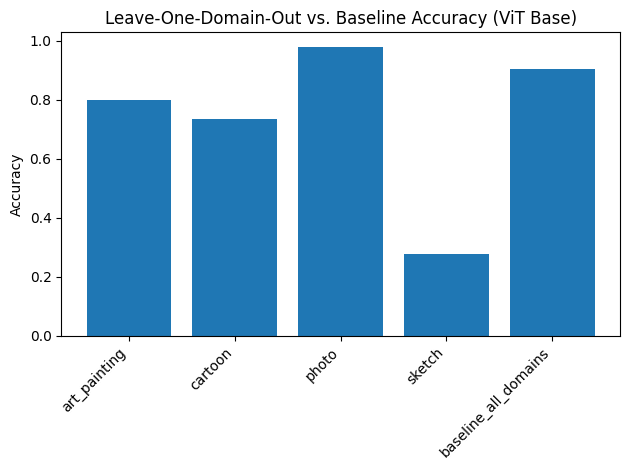

In [16]:
domains = list(results_base.keys())
accuracies = [results_base[d] for d in domains]

plt.figure()
plt.bar(domains, accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Leave-One-Domain-Out vs. Baseline Accuracy (ViT Base)')
plt.tight_layout()
plt.show()

### Final Results

In [17]:

print("\Final Results (LODO Accuracy):")
for domain, acc in results_base.items():
    print(f"{domain}: {acc:.4f}")

avg_acc = sum(results_base.values()) / len(results_base)
print(f"\nAverage Accuracy: {avg_acc:.4f}")


\Final Results (LODO Accuracy):
art_painting: 0.8000
cartoon: 0.7356
photo: 0.9790
sketch: 0.2786
baseline_all_domains: 0.9025

Average Accuracy: 0.7391


<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_12940\165815634.py:1: SyntaxWarning: invalid escape sequence '\F'
  print("\Final Results (LODO Accuracy):")


## WinKawaks/ViT Small

### Leave-One-Domain-Out (LODO) Training

In [18]:
# =================================================================================
# GRQO + ViT Small Leave-One-Domain-Out (LODO) Training (Corrected)
# =================================================================================

# Define the image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

results_small = {}
for test_domain in DOMAINS:
    print(f"---[ViT Small]--- Testing on domain: {test_domain} ---")
    train_domains = [d for d in DOMAINS if d != test_domain]
    dataset = PACSDataset(DATA_ROOT, DOMAINS, transform)
    train_loaders = [dataset.get_dataloader(d, train=True) for d in train_domains]
    val_loaders = [dataset.get_dataloader(d, train=False) for d in train_domains]
    test_loader = dataset.get_dataloader(test_domain, train=False)
    train_ds = ConcatDataset([dl.dataset for dl in train_loaders])
    val_ds = ConcatDataset([dl.dataset for dl in val_loaders])
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    model_small = ViT_GRQO_Model(NUM_CLASSES, "small", NUM_QUERIES, NUM_DECODER_LAYERS, DECODER_NHEAD)
    optimizer_small = optim.Adam(model_small.parameters(), lr=1e-4)
    criterion_small = nn.CrossEntropyLoss()
    trainer_small = Trainer(model_small, optimizer_small, criterion_small, GRQO_ALPHA, GRQO_BETA, WARMUP_EPOCHS)

    for epoch in range(NUM_EPOCHS):
        if epoch >= WARMUP_EPOCHS:
            trainer_small.update_reference_model()

        train_loss_small = trainer_small.train(train_loader, current_epoch=epoch)
        val_acc_small = trainer_small.evaluate(val_loader)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Train Loss: {train_loss_small:.4f} | Val Acc: {val_acc_small:.4f}")

    test_acc_small = trainer_small.evaluate(test_loader)
    results_small[test_domain] = test_acc_small
    print(f"Final Test Accuracy on {test_domain}: {test_acc_small:.4f}\n")

# --- ViT Small Baseline ---
print("\n---[ViT Small]--- Baseline: training on all domains with GRQO ---")
dataset_all = PACSDataset(DATA_ROOT, DOMAINS, transform)
all_train_loaders = [dataset_all.get_dataloader(d, train=True) for d in DOMAINS]
all_test_loaders = [dataset_all.get_dataloader(d, train=False) for d in DOMAINS]
full_train_ds = ConcatDataset([dl.dataset for dl in all_train_loaders])
full_test_ds = ConcatDataset([dl.dataset for dl in all_test_loaders])
full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

baseline_model_small = ViT_GRQO_Model(NUM_CLASSES, "small", NUM_QUERIES, NUM_DECODER_LAYERS, DECODER_NHEAD)
baseline_optimizer_small = optim.Adam(baseline_model_small.parameters(), lr=1e-4)
baseline_criterion_small = nn.CrossEntropyLoss()
baseline_trainer_small = Trainer(baseline_model_small, baseline_optimizer_small, baseline_criterion_small, GRQO_ALPHA, GRQO_BETA, WARMUP_EPOCHS)

for epoch in range(NUM_EPOCHS):
    if epoch >= WARMUP_EPOCHS:
        baseline_trainer_small.update_reference_model()

    baseline_loss_small = baseline_trainer_small.train(full_train_loader, current_epoch=epoch)
    baseline_val_acc_small = baseline_trainer_small.evaluate(full_test_loader)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Baseline Loss: {baseline_loss_small:.4f} | Baseline Acc: {baseline_val_acc_small:.4f}")

baseline_test_acc_small = baseline_trainer_small.evaluate(full_test_loader)
results_small['baseline_all_domains'] = baseline_test_acc_small
print(f"Final Baseline Test Accuracy: {baseline_test_acc_small:.4f}\n")

---[ViT Small]--- Testing on domain: art_painting ---


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized ViT-GRQO Model (ViT-small) with 30 queries.
Initialized Trainer with 1 SFT warm-up epoch(s).
GRQO params (alpha=1.0, beta=0.05) will activate after warm-up.


Evaluating: 100%|██████████| 67/67 [00:02<00:00, 22.78it/s]


Epoch 1/5 -> Train Loss: 0.3131 | Val Acc: 0.9471
--- Initializing reference model for GRQO phase ---


Evaluating: 100%|██████████| 67/67 [00:02<00:00, 22.94it/s]


Epoch 2/5 -> Train Loss: -1.7432 | Val Acc: 0.9484


Evaluating: 100%|██████████| 67/67 [00:03<00:00, 22.16it/s]


Epoch 3/5 -> Train Loss: -10.5081 | Val Acc: 0.9509


Evaluating: 100%|██████████| 67/67 [00:03<00:00, 21.58it/s]


Epoch 4/5 -> Train Loss: -17.6193 | Val Acc: 0.9452


Evaluating: 100%|██████████| 67/67 [00:03<00:00, 22.23it/s]


Epoch 5/5 -> Train Loss: -24.8715 | Val Acc: 0.9069


Evaluating: 100%|██████████| 18/18 [00:00<00:00, 21.34it/s]


Final Test Accuracy on art_painting: 0.7122

---[ViT Small]--- Testing on domain: cartoon ---


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized ViT-GRQO Model (ViT-small) with 30 queries.
Initialized Trainer with 1 SFT warm-up epoch(s).
GRQO params (alpha=1.0, beta=0.05) will activate after warm-up.


Evaluating: 100%|██████████| 64/64 [00:02<00:00, 22.56it/s]


Epoch 1/5 -> Train Loss: 0.3201 | Val Acc: 0.9346
--- Initializing reference model for GRQO phase ---


Evaluating: 100%|██████████| 64/64 [00:02<00:00, 22.90it/s]


Epoch 2/5 -> Train Loss: -1.1824 | Val Acc: 0.9431


Evaluating: 100%|██████████| 64/64 [00:02<00:00, 22.45it/s]


Epoch 3/5 -> Train Loss: -7.1439 | Val Acc: 0.9163


Evaluating: 100%|██████████| 64/64 [00:02<00:00, 22.95it/s]


Epoch 4/5 -> Train Loss: -11.6946 | Val Acc: 0.9026


Evaluating: 100%|██████████| 64/64 [00:02<00:00, 23.25it/s]


Epoch 5/5 -> Train Loss: -16.4534 | Val Acc: 0.9359


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 21.59it/s]


Final Test Accuracy on cartoon: 0.8060

---[ViT Small]--- Testing on domain: photo ---


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized ViT-GRQO Model (ViT-small) with 30 queries.
Initialized Trainer with 1 SFT warm-up epoch(s).
GRQO params (alpha=1.0, beta=0.05) will activate after warm-up.


Evaluating: 100%|██████████| 70/70 [00:03<00:00, 22.34it/s]


Epoch 1/5 -> Train Loss: 0.3263 | Val Acc: 0.9471
--- Initializing reference model for GRQO phase ---


Evaluating: 100%|██████████| 70/70 [00:03<00:00, 22.22it/s]


Epoch 2/5 -> Train Loss: -1.0791 | Val Acc: 0.8721


Evaluating: 100%|██████████| 70/70 [00:03<00:00, 22.90it/s]


Epoch 3/5 -> Train Loss: -9.8043 | Val Acc: 0.9375


Evaluating: 100%|██████████| 70/70 [00:03<00:00, 22.11it/s]


Epoch 4/5 -> Train Loss: -17.4083 | Val Acc: 0.9075


Evaluating: 100%|██████████| 70/70 [00:03<00:00, 23.12it/s]


Epoch 5/5 -> Train Loss: -24.8999 | Val Acc: 0.8793


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 21.54it/s]


Final Test Accuracy on photo: 0.9431

---[ViT Small]--- Testing on domain: sketch ---


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized ViT-GRQO Model (ViT-small) with 30 queries.
Initialized Trainer with 1 SFT warm-up epoch(s).
GRQO params (alpha=1.0, beta=0.05) will activate after warm-up.


Evaluating: 100%|██████████| 51/51 [00:02<00:00, 21.82it/s]


Epoch 1/5 -> Train Loss: 0.2426 | Val Acc: 0.9497
--- Initializing reference model for GRQO phase ---


Evaluating: 100%|██████████| 51/51 [00:02<00:00, 22.50it/s]


Epoch 2/5 -> Train Loss: -0.5159 | Val Acc: 0.9406


Evaluating: 100%|██████████| 51/51 [00:02<00:00, 23.15it/s]


Epoch 3/5 -> Train Loss: -7.0425 | Val Acc: 0.9349


Evaluating: 100%|██████████| 51/51 [00:02<00:00, 22.22it/s]


Epoch 4/5 -> Train Loss: -12.1677 | Val Acc: 0.9481


Evaluating: 100%|██████████| 51/51 [00:02<00:00, 21.66it/s]


Epoch 5/5 -> Train Loss: -17.2910 | Val Acc: 0.9505


Evaluating: 100%|██████████| 33/33 [00:01<00:00, 21.01it/s]


Final Test Accuracy on sketch: 0.6985


---[ViT Small]--- Baseline: training on all domains with GRQO ---


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized ViT-GRQO Model (ViT-small) with 30 queries.
Initialized Trainer with 1 SFT warm-up epoch(s).
GRQO params (alpha=1.0, beta=0.05) will activate after warm-up.


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 22.31it/s]


Epoch 1/5 -> Baseline Loss: 0.3038 | Baseline Acc: 0.9360
--- Initializing reference model for GRQO phase ---


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 22.23it/s]


Epoch 2/5 -> Baseline Loss: -2.0047 | Baseline Acc: 0.9320


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 21.99it/s]


Epoch 3/5 -> Baseline Loss: -13.4380 | Baseline Acc: 0.9410


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 21.15it/s]


Epoch 4/5 -> Baseline Loss: -23.2415 | Baseline Acc: 0.9415


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 21.06it/s]


Epoch 5/5 -> Baseline Loss: -33.7362 | Baseline Acc: 0.9165


Evaluating: 100%|██████████| 84/84 [00:04<00:00, 20.09it/s]

Final Baseline Test Accuracy: 0.9165



### Baseline

In [19]:
# # =================================================================================
# # GRQO + ViT Small Baseline Training (All Domains)
# # =================================================================================

# print("\n---[ViT Small]--- Baseline: training on all domains with GRQO ---")

# # Data loading is the same as the 'base' baseline
# full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
# full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

# # --- Initialize baseline model with GRQO ---
# baseline_model_small = ViT_GRQO_Model(
#     num_classes=NUM_CLASSES, 
#     model_size="small",
#     num_queries=NUM_QUERIES,
#     num_decoder_layers=NUM_DECODER_LAYERS,
#     decoder_nhead=DECODER_NHEAD
# )
# baseline_optimizer_small = optim.Adam(baseline_model_small.parameters(), lr=1e-4)
# baseline_criterion_small = nn.CrossEntropyLoss()

# baseline_trainer_small = Trainer(
#     baseline_model_small, 
#     baseline_optimizer_small, 
#     baseline_criterion_small,
#     grqo_alpha=GRQO_ALPHA, 
#     grqo_beta=GRQO_BETA
# )

# # --- Train baseline ---
# for epoch in range(NUM_EPOCHS):
#     print(f"Baseline Epoch {epoch + 1}/{NUM_EPOCHS}")
#     baseline_trainer_small.update_reference_model()

#     baseline_loss_small = baseline_trainer_small.train(full_train_loader)
#     baseline_val_acc_small = baseline_trainer_small.evaluate(full_test_loader)
#     print(f"Baseline Loss: {baseline_loss_small:.4f} | Baseline Acc: {baseline_val_acc_small:.4f}")

# # --- Test baseline ---
# baseline_test_acc_small = baseline_trainer_small.evaluate(full_test_loader)
# results_small['baseline_all_domains'] = baseline_test_acc_small
# print(f"Baseline Test Accuracy: {baseline_test_acc_small:.4f}")

### Visual Comparison

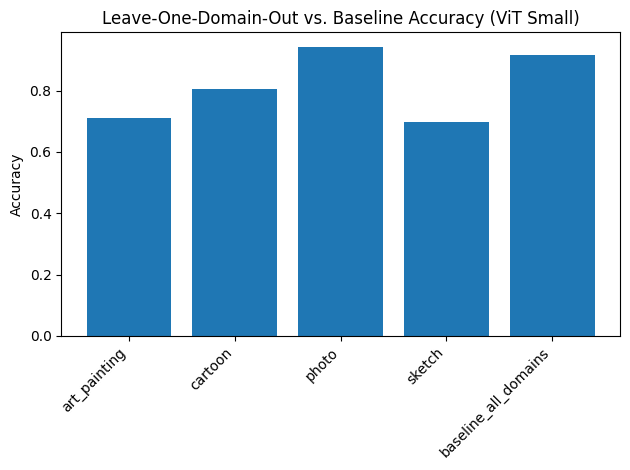

In [20]:
domains = list(results_small.keys())
accuracies = [results_small[d] for d in domains]

plt.figure()
plt.bar(domains, accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Leave-One-Domain-Out vs. Baseline Accuracy (ViT Small)')
plt.tight_layout()
plt.show()

### Final Results

In [21]:

print("\Final Results (LODO Accuracy):")
for domain, acc in results_small.items():
    print(f"{domain}: {acc:.4f}")

avg_acc = sum(results_small.values()) / len(results_small)
print(f"\nAverage Accuracy: {avg_acc:.4f}")


\Final Results (LODO Accuracy):
art_painting: 0.7122
cartoon: 0.8060
photo: 0.9431
sketch: 0.6985
baseline_all_domains: 0.9165

Average Accuracy: 0.8152


<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_12940\3963232904.py:1: SyntaxWarning: invalid escape sequence '\F'
  print("\Final Results (LODO Accuracy):")


## WinKawaks/ViT Tiny

### Leave-One-Domain-Out (LODO) Training

In [22]:
# =================================================================================
# GRQO + ViT Tiny Leave-One-Domain-Out (LODO) Training (Corrected)
# =================================================================================

# Define the image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

results_tiny = {}
for test_domain in DOMAINS:
    print(f"---[ViT Tiny]--- Testing on domain: {test_domain} ---")
    train_domains = [d for d in DOMAINS if d != test_domain]
    dataset = PACSDataset(DATA_ROOT, DOMAINS, transform)
    train_loaders = [dataset.get_dataloader(d, train=True) for d in train_domains]
    val_loaders = [dataset.get_dataloader(d, train=False) for d in train_domains]
    test_loader = dataset.get_dataloader(test_domain, train=False)
    train_ds = ConcatDataset([dl.dataset for dl in train_loaders])
    val_ds = ConcatDataset([dl.dataset for dl in val_loaders])
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    model_tiny = ViT_GRQO_Model(NUM_CLASSES, "tiny", NUM_QUERIES, NUM_DECODER_LAYERS, DECODER_NHEAD)
    optimizer_tiny = optim.Adam(model_tiny.parameters(), lr=1e-4)
    criterion_tiny = nn.CrossEntropyLoss()
    trainer_tiny = Trainer(model_tiny, optimizer_tiny, criterion_tiny, GRQO_ALPHA, GRQO_BETA, WARMUP_EPOCHS)

    for epoch in range(NUM_EPOCHS):
        if epoch >= WARMUP_EPOCHS:
            trainer_tiny.update_reference_model()

        train_loss_tiny = trainer_tiny.train(train_loader, current_epoch=epoch)
        val_acc_tiny = trainer_tiny.evaluate(val_loader)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Train Loss: {train_loss_tiny:.4f} | Val Acc: {val_acc_tiny:.4f}")

    test_acc_tiny = trainer_tiny.evaluate(test_loader)
    results_tiny[test_domain] = test_acc_tiny
    print(f"Final Test Accuracy on {test_domain}: {test_acc_tiny:.4f}\n")

# --- ViT Tiny Baseline ---
print("\n---[ViT Tiny]--- Baseline: training on all domains with GRQO ---")
dataset_all = PACSDataset(DATA_ROOT, DOMAINS, transform)
all_train_loaders = [dataset_all.get_dataloader(d, train=True) for d in DOMAINS]
all_test_loaders = [dataset_all.get_dataloader(d, train=False) for d in DOMAINS]
full_train_ds = ConcatDataset([dl.dataset for dl in all_train_loaders])
full_test_ds = ConcatDataset([dl.dataset for dl in all_test_loaders])
full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

baseline_model_tiny = ViT_GRQO_Model(NUM_CLASSES, "tiny", NUM_QUERIES, NUM_DECODER_LAYERS, DECODER_NHEAD)
baseline_optimizer_tiny = optim.Adam(baseline_model_tiny.parameters(), lr=1e-4)
baseline_criterion_tiny = nn.CrossEntropyLoss()
baseline_trainer_tiny = Trainer(baseline_model_tiny, baseline_optimizer_tiny, baseline_criterion_tiny, GRQO_ALPHA, GRQO_BETA, WARMUP_EPOCHS)

for epoch in range(NUM_EPOCHS):
    if epoch >= WARMUP_EPOCHS:
        baseline_trainer_tiny.update_reference_model()

    baseline_loss_tiny = baseline_trainer_tiny.train(full_train_loader, current_epoch=epoch)
    baseline_val_acc_tiny = baseline_trainer_tiny.evaluate(full_test_loader)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Baseline Loss: {baseline_loss_tiny:.4f} | Baseline Acc: {baseline_val_acc_tiny:.4f}")

baseline_test_acc_tiny = baseline_trainer_tiny.evaluate(full_test_loader)
results_tiny['baseline_all_domains'] = baseline_test_acc_tiny
print(f"Final Baseline Test Accuracy: {baseline_test_acc_tiny:.4f}\n")

---[ViT Tiny]--- Testing on domain: art_painting ---


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized ViT-GRQO Model (ViT-tiny) with 30 queries.
Initialized Trainer with 1 SFT warm-up epoch(s).
GRQO params (alpha=1.0, beta=0.05) will activate after warm-up.


Evaluating: 100%|██████████| 67/67 [00:02<00:00, 23.10it/s]


Epoch 1/5 -> Train Loss: 0.4959 | Val Acc: 0.8672
--- Initializing reference model for GRQO phase ---


Evaluating: 100%|██████████| 67/67 [00:02<00:00, 22.87it/s]


Epoch 2/5 -> Train Loss: -0.2176 | Val Acc: 0.8811


Evaluating: 100%|██████████| 67/67 [00:02<00:00, 22.88it/s]


Epoch 3/5 -> Train Loss: -5.7248 | Val Acc: 0.9075


Evaluating: 100%|██████████| 67/67 [00:02<00:00, 23.73it/s]


Epoch 4/5 -> Train Loss: -10.2763 | Val Acc: 0.9012


Evaluating: 100%|██████████| 67/67 [00:02<00:00, 23.88it/s]


Epoch 5/5 -> Train Loss: -14.8573 | Val Acc: 0.9402


Evaluating: 100%|██████████| 18/18 [00:00<00:00, 22.82it/s]


Final Test Accuracy on art_painting: 0.7122

---[ViT Tiny]--- Testing on domain: cartoon ---


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized ViT-GRQO Model (ViT-tiny) with 30 queries.
Initialized Trainer with 1 SFT warm-up epoch(s).
GRQO params (alpha=1.0, beta=0.05) will activate after warm-up.


Evaluating: 100%|██████████| 64/64 [00:02<00:00, 24.73it/s]


Epoch 1/5 -> Train Loss: 0.4653 | Val Acc: 0.9111
--- Initializing reference model for GRQO phase ---


Evaluating: 100%|██████████| 64/64 [00:02<00:00, 23.37it/s]


Epoch 2/5 -> Train Loss: -0.2649 | Val Acc: 0.9059


Evaluating: 100%|██████████| 64/64 [00:02<00:00, 24.63it/s]


Epoch 3/5 -> Train Loss: -5.8141 | Val Acc: 0.8856


Evaluating: 100%|██████████| 64/64 [00:02<00:00, 26.51it/s]


Epoch 4/5 -> Train Loss: -10.1977 | Val Acc: 0.8830


Evaluating: 100%|██████████| 64/64 [00:02<00:00, 26.40it/s]


Epoch 5/5 -> Train Loss: -14.4430 | Val Acc: 0.8980


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 25.68it/s]


Final Test Accuracy on cartoon: 0.7186

---[ViT Tiny]--- Testing on domain: photo ---


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized ViT-GRQO Model (ViT-tiny) with 30 queries.
Initialized Trainer with 1 SFT warm-up epoch(s).
GRQO params (alpha=1.0, beta=0.05) will activate after warm-up.


Evaluating: 100%|██████████| 70/70 [00:02<00:00, 25.50it/s]


Epoch 1/5 -> Train Loss: 0.5325 | Val Acc: 0.9045
--- Initializing reference model for GRQO phase ---


Evaluating: 100%|██████████| 70/70 [00:02<00:00, 25.94it/s]


Epoch 2/5 -> Train Loss: -0.5370 | Val Acc: 0.8799


Evaluating: 100%|██████████| 70/70 [00:02<00:00, 26.16it/s]


Epoch 3/5 -> Train Loss: -6.4793 | Val Acc: 0.9003


Evaluating: 100%|██████████| 70/70 [00:02<00:00, 25.39it/s]


Epoch 4/5 -> Train Loss: -10.9616 | Val Acc: 0.9045


Evaluating: 100%|██████████| 70/70 [00:02<00:00, 25.27it/s]


Epoch 5/5 -> Train Loss: -15.3060 | Val Acc: 0.8901


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 23.76it/s]


Final Test Accuracy on photo: 0.9371

---[ViT Tiny]--- Testing on domain: sketch ---


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized ViT-GRQO Model (ViT-tiny) with 30 queries.
Initialized Trainer with 1 SFT warm-up epoch(s).
GRQO params (alpha=1.0, beta=0.05) will activate after warm-up.


Evaluating: 100%|██████████| 51/51 [00:01<00:00, 25.81it/s]


Epoch 1/5 -> Train Loss: 0.3657 | Val Acc: 0.9308
--- Initializing reference model for GRQO phase ---


Evaluating: 100%|██████████| 51/51 [00:01<00:00, 26.37it/s]


Epoch 2/5 -> Train Loss: 0.2252 | Val Acc: 0.9126


Evaluating: 100%|██████████| 51/51 [00:01<00:00, 26.38it/s]


Epoch 3/5 -> Train Loss: -1.9990 | Val Acc: 0.9308


Evaluating: 100%|██████████| 51/51 [00:01<00:00, 25.77it/s]


Epoch 4/5 -> Train Loss: -6.8544 | Val Acc: 0.9077


Evaluating: 100%|██████████| 51/51 [00:01<00:00, 26.81it/s]


Epoch 5/5 -> Train Loss: -10.0740 | Val Acc: 0.9052


Evaluating: 100%|██████████| 33/33 [00:01<00:00, 26.48it/s]


Final Test Accuracy on sketch: 0.5331


---[ViT Tiny]--- Baseline: training on all domains with GRQO ---


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized ViT-GRQO Model (ViT-tiny) with 30 queries.
Initialized Trainer with 1 SFT warm-up epoch(s).
GRQO params (alpha=1.0, beta=0.05) will activate after warm-up.


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 27.37it/s]


Epoch 1/5 -> Baseline Loss: 0.4587 | Baseline Acc: 0.9305
--- Initializing reference model for GRQO phase ---


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 27.00it/s]


Epoch 2/5 -> Baseline Loss: -0.5266 | Baseline Acc: 0.9065


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 23.99it/s]


Epoch 3/5 -> Baseline Loss: -7.4990 | Baseline Acc: 0.8564


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 24.55it/s]


Epoch 4/5 -> Baseline Loss: -13.3584 | Baseline Acc: 0.9160


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 25.71it/s]


Epoch 5/5 -> Baseline Loss: -19.6337 | Baseline Acc: 0.8724


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 21.98it/s]

Final Baseline Test Accuracy: 0.8724



### Baseline

In [23]:
# # =================================================================================
# # GRQO + ViT Tiny Baseline Training (All Domains)
# # =================================================================================

# print("\n---[ViT Tiny]--- Baseline: training on all domains with GRQO ---")

# # Data loading is the same as the 'base' baseline
# full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
# full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

# # --- Initialize baseline model with GRQO ---
# baseline_model_tiny = ViT_GRQO_Model(
#     num_classes=NUM_CLASSES, 
#     model_size="tiny",
#     num_queries=NUM_QUERIES,
#     num_decoder_layers=NUM_DECODER_LAYERS,
#     decoder_nhead=DECODER_NHEAD
# )
# baseline_optimizer_tiny = optim.Adam(baseline_model_tiny.parameters(), lr=1e-4)
# baseline_criterion_tiny = nn.CrossEntropyLoss()

# baseline_trainer_tiny = Trainer(
#     baseline_model_tiny, 
#     baseline_optimizer_tiny, 
#     baseline_criterion_tiny,
#     grqo_alpha=GRQO_ALPHA, 
#     grqo_beta=GRQO_BETA
# )

# # --- Train baseline ---
# for epoch in range(NUM_EPOCHS):
#     print(f"Baseline Epoch {epoch + 1}/{NUM_EPOCHS}")
#     baseline_trainer_tiny.update_reference_model()

#     baseline_loss_tiny = baseline_trainer_tiny.train(full_train_loader)
#     baseline_val_acc_tiny = baseline_trainer_tiny.evaluate(full_test_loader)
#     print(f"Baseline Loss: {baseline_loss_tiny:.4f} | Baseline Acc: {baseline_val_acc_tiny:.4f}")

# # --- Test baseline ---
# baseline_test_acc_tiny = baseline_trainer_tiny.evaluate(full_test_loader)
# results_tiny['baseline_all_domains'] = baseline_test_acc_tiny
# print(f"Baseline Test Accuracy: {baseline_test_acc_tiny:.4f}")

### Visual Comparison

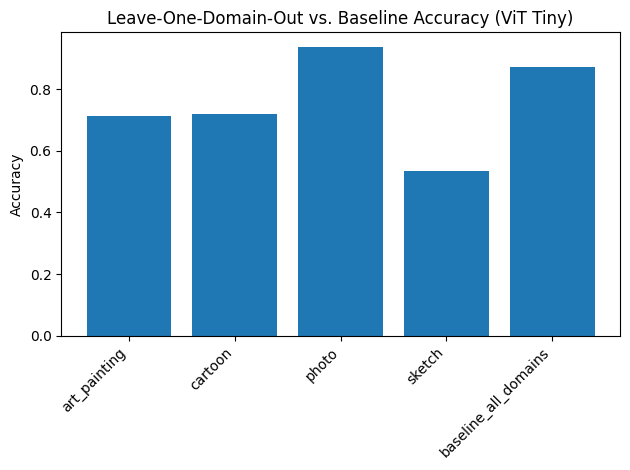

In [24]:
domains = list(results_tiny.keys())
accuracies = [results_tiny[d] for d in domains]

plt.figure()
plt.bar(domains, accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Leave-One-Domain-Out vs. Baseline Accuracy (ViT Tiny)')
plt.tight_layout()
plt.show()

### Final Results

In [25]:

print("\Final Results (LODO Accuracy):")
for domain, acc in results_tiny.items():
    print(f"{domain}: {acc:.4f}")

avg_acc = sum(results_tiny.values()) / len(results_tiny)
print(f"\nAverage Accuracy: {avg_acc:.4f}")


\Final Results (LODO Accuracy):
art_painting: 0.7122
cartoon: 0.7186
photo: 0.9371
sketch: 0.5331
baseline_all_domains: 0.8724

Average Accuracy: 0.7547


<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_12940\1740940439.py:1: SyntaxWarning: invalid escape sequence '\F'
  print("\Final Results (LODO Accuracy):")


## Performance Comparison

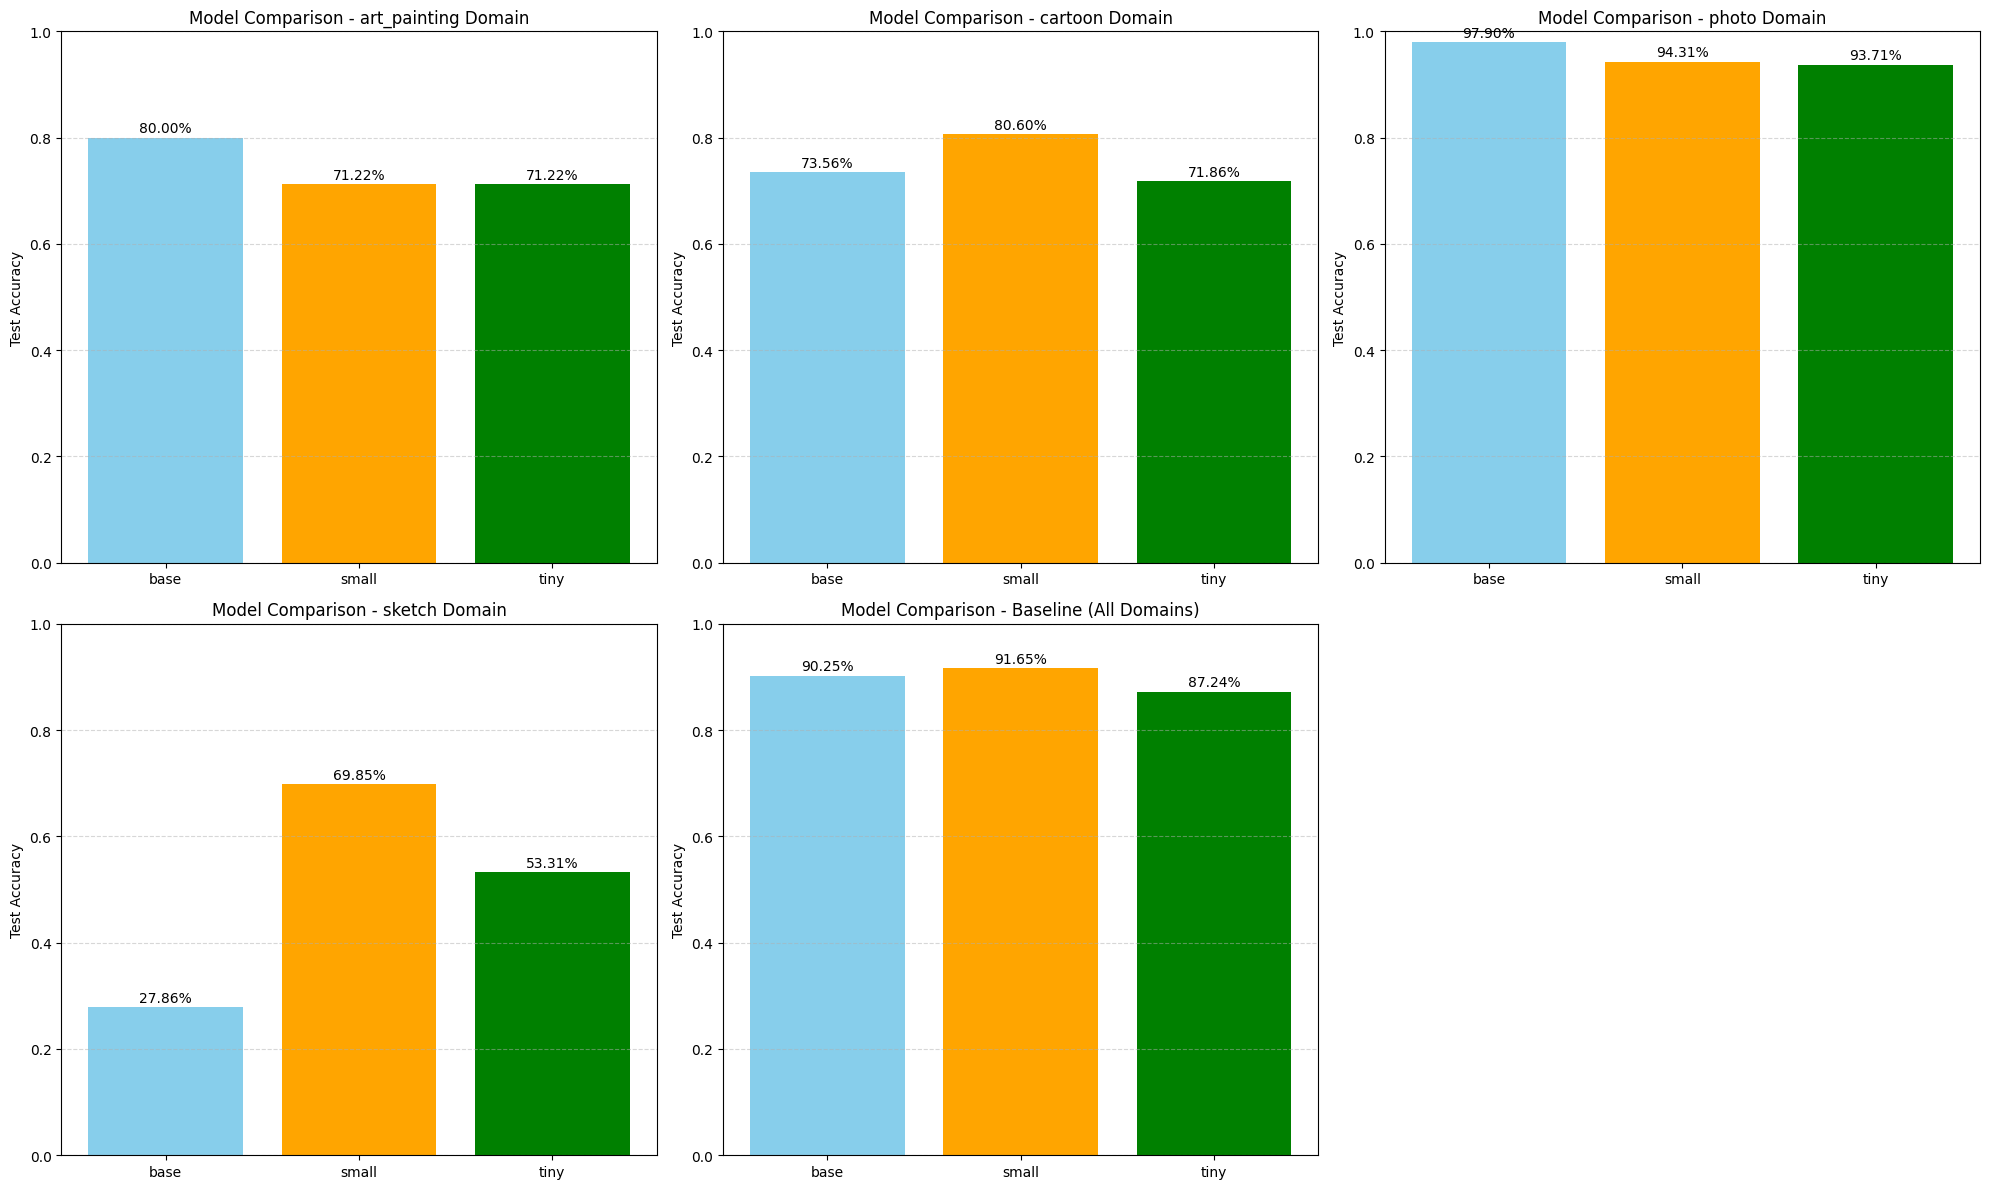


Detailed Performance Comparison:
------------------------------------------------------------
Domain                Base      Small       Tiny
------------------------------------------------------------
art_painting        80.00%     71.22%     71.22%
cartoon             73.56%     80.60%     71.86%
photo               97.90%     94.31%     93.71%
sketch              27.86%     69.85%     53.31%
------------------------------------------------------------
Baseline            90.25%     91.65%     87.24%
------------------------------------------------------------


In [26]:
plt.figure(figsize=(20, 12))

for idx, domain in enumerate(DOMAINS):
    plt.subplot(2, 3, idx + 1)

    domain_accuracies = [
        results_base[domain],
        results_small[domain],
        results_tiny[domain]
    ]

    bars = plt.bar(MODELS.keys(), domain_accuracies, color=["skyblue", "orange", "green"])
    plt.ylim(0, 1)
    plt.ylabel("Test Accuracy")
    plt.title(f"Model Comparison - {domain} Domain")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    
    # Add value labels on top of bars
    for i, acc in enumerate(domain_accuracies):
        plt.text(i, acc + 0.01, f"{acc:.2%}", ha="center")

# Create the baseline comparison subplot
plt.subplot(2, 3, 5) 
baseline_accuracies = [
    results_base["baseline_all_domains"],
    results_small["baseline_all_domains"],
    results_tiny["baseline_all_domains"]
]
plt.bar(MODELS.keys(), baseline_accuracies, color=["skyblue", "orange", "green"])
plt.ylim(0, 1)
plt.ylabel("Test Accuracy")
plt.title("Model Comparison - Baseline (All Domains)")
plt.grid(axis="y", linestyle="--", alpha=0.5)

for i, acc in enumerate(baseline_accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2%}", ha="center")

plt.tight_layout()
plt.show()

print("\nDetailed Performance Comparison:")
print("-" * 60)
print(f"{'Domain':<15} {'Base':>10} {'Small':>10} {'Tiny':>10}")
print("-" * 60)

for domain in DOMAINS:
    print(f"{domain:<15} {results_base[domain]:>10.2%} {results_small[domain]:>10.2%} {results_tiny[domain]:>10.2%}")

print("-" * 60)
print(f"{'Baseline':<15} {results_base['baseline_all_domains']:>10.2%} {results_small['baseline_all_domains']:>10.2%} {results_tiny['baseline_all_domains']:>10.2%}")
print("-" * 60)